In [1]:
import re
from collections import Counter
from itertools import cycle, product, chain
import numpy as np
from math import sqrt, hypot
from copy import deepcopy

from PIL import Image, ImageDraw
import rstr

### Візуалізація шахматної доски

In [2]:
def expand(match):
    return ' ' * int(match.group(0))

In [3]:
def expand_blanks(fen):
    return re.compile(r'\d').sub(expand, fen)

In [4]:
def check_fen(expanded_fen, n):
    match = re.compile(r'([KQBNRPkqbnrp ]{{{n}}}/){{{n}}}$'.format(n=n)).match
    if not match(expanded_fen + '/'):
        print('Board is not Valid')

In [5]:
def expand_fen(fen, n):
    expanded = expand_blanks(fen)
    check_fen(expanded, n)
    return expanded.replace('/', '')

In [6]:
def square_board(i, j, sq_size):
    return i * sq_size[0], j * sq_size[1]

In [7]:
def draw_board(size=8, sq_size=(20, 20)):
    piece_w, piece_h = sq_size
    
    opaque_grey_background = 192, 255
    board = Image.new('LA', square_board(size, size, sq_size), opaque_grey_background) 
    draw_square = ImageDraw.Draw(board).rectangle
    
    whites = ((square_board(i, j, sq_size), square_board(i + 1, j + 1, sq_size))
              for i_start, j in zip(cycle((0, 1)), range(size))
              for i in range(i_start, size, 2))
    
    for white_square in whites:
        draw_square(white_square, fill='white')
    return board

In [8]:
def load_pieces():
    whites = 'KQBNRP'
    piece_images = dict(
        zip(whites, (Image.open('Pieces_Folder/%s.png' % p) for p in whites)))    
    piece_sizes = set(piece.size for piece in piece_images.values())
    piece_w, piece_h = piece_sizes.pop()
    piece_masks = dict((pc, img.split()[3]) for pc, img in piece_images.items())
    
    return piece_w, piece_h, piece_images, piece_masks

In [9]:
def create_blank_board(piece_w, piece_h, size):
    
    board = draw_board(size, sq_size=(piece_w, piece_h))
    
    return board


def point(piece_w, piece_h, i, j):
    return i * piece_h, j * piece_w


def square(piece_w, piece_h, i, j):
    t, l = point(piece_w, piece_h, i, j)
    b, r = point(piece_w, piece_h, i + 1, j + 1)
    return t, l, b, r

def not_blank(pt_pc):
    return pt_pc[1] != ' '
    
def draw(size, fen):
    piece_w, piece_h, piece_images, piece_masks = load_pieces()
    
    board = create_blank_board(piece_w, piece_h, size).copy()
    
    pieces = expand_fen(fen, size)
    
    images, masks = piece_images, piece_masks
    pts = (point(piece_w, piece_h, i, j) for j in range(size) for i in range(size))
    
    for pt, piece in filter(not_blank, zip(pts, pieces)):
        board.paste(images[piece], pt, masks[piece])
    return board

In [10]:
fen = "R2Q1RK1NB/B2Q1RK1NB/PP2PPBPNR/1NP2NP1NP/2Q3B1PR/3PP1B1KN/2N2N2PN/PP3PPPKN/3RKB1RRN/3RKB1RRN"
board = draw(10, fen)

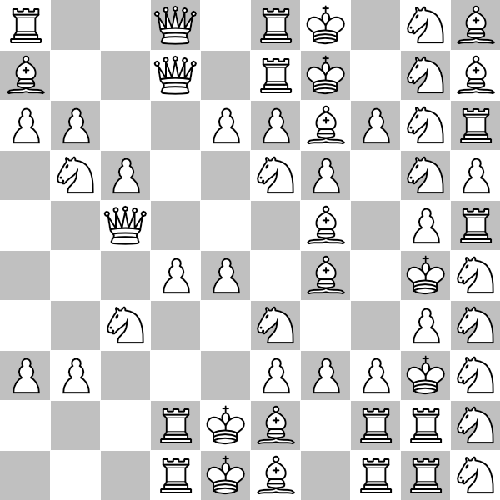

In [11]:
board.resize((500, 500))

### Генерація випадкової шахматної доски

In [12]:
REGEX = r'([{figures} ]{{{n}}}/){{{n}}}$'

In [13]:
def create_chess_board(size, config, rename_mapping, whites, blacks, regex=REGEX):
    regex_tmp = regex.format(figures=('').join(config.keys()), n=size)
    gen = rstr.xeger(regex_tmp)
    
    gen_list = gen.split('/')[:-1]
    
    for i, row in enumerate(gen_list):
        for j, el in enumerate(row):
            if (i % 2 == 0) and (j % 2 != 0) and el in whites:
                row = row[:j] + ' ' + row[j + 1:]
                gen_list[i] = row
            elif (i % 2 == 0) and (j % 2 == 0) and el in blacks:
                row = row[:j] + ' ' + row[j + 1:]
                gen_list[i] = row
            elif (i % 2 != 0) and (j % 2 == 0) and el in whites:
                row = row[:j] + ' ' + row[j + 1:]
                gen_list[i] = row
            elif (i % 2 != 0) and (j % 2 != 0) and el in blacks:
                row = row[:j] + ' ' + row[j + 1:]
                gen_list[i] = row
    
    gen_list = ('/').join(gen_list)

    counter = Counter(gen_list)
    
    for piece, qty in config.items():
        real_qty = counter.get(piece)
        while real_qty > qty:
            for i, el in enumerate(gen_list):
                if el == piece and np.random.uniform(0, 1) > 0.5 and real_qty > qty:
                    gen_list = gen_list[:i] + ' ' + gen_list[i + 1:]
                    real_qty -= 1
                             
    for to_rename, value in rename_mapping.items():
        gen_list = gen_list.replace(to_rename, value)
    
    renamed_config = {}
    for fig, val in config.items():
        if rename_mapping.get(fig):
            renamed_config[rename_mapping.get(fig)] = val
        else:
            renamed_config[fig] = val
    
    figures_mapping = {}
    coords = np.zeros((size, size))
    
    for i, row in enumerate(gen_list.split('/')):
        for j, col in enumerate(row):
            number = renamed_config.get(col)
            if number:
                coords[i, j] = number
                figures_mapping[(i, j)] = col

    return gen_list, figures_mapping, coords

In [14]:
# 'Q' - Королева
# 'P' - Пішак
# 'R' - Тура
# 'S' - білопольний кінь
# 'L' - чорнопольний кінь
# 'M' - білопольний слон
# 'D' - чорнопольний слон
# 'N' - кінь
# 'K' - Король
# 'B' - слон

CONFIG = {'N':2, 'M': 4, 'D':4}
SIZE = 4
RENAME_MAPPING = {
                  'M': 'B',
                  'D': 'B'
                 }

In [15]:
gen_list, figures_mapping, coords = create_chess_board(SIZE, CONFIG, RENAME_MAPPING, ['M'], ['L', 'D'])

In [16]:
# gen_list

In [17]:
board = draw(SIZE, gen_list)

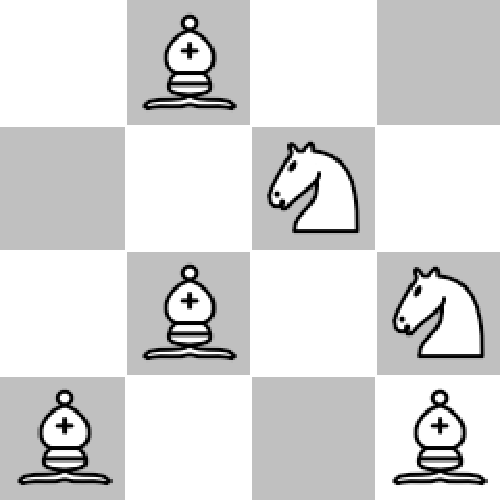

In [18]:
board.resize((500, 500))

In [19]:
figures_mapping

{(0, 1): 'B', (1, 2): 'N', (2, 1): 'B', (2, 3): 'N', (3, 0): 'B', (3, 3): 'B'}

In [20]:
coords

array([[0., 4., 0., 0.],
       [0., 0., 2., 0.],
       [0., 4., 0., 2.],
       [4., 0., 0., 4.]])

### Правила гри для фігур

In [21]:
def pawn_rule(pawn_coordinates, target_coordinates, board_size):
    x, y = pawn_coordinates

    all_coordinates = list(product(range(board_size), range(board_size)))
    possible_coordinates = (coord for coord in all_coordinates
                            if (abs(x - coord[0]) == 1 and y - coord[1] == 1)
                            )

    possible_coordinates = list(set(possible_coordinates))
    
    return possible_coordinates


def knight_rule(knight_coordinates, target_coordinates, board_size):
    x, y = knight_coordinates

    all_coordinates = list(product(range(board_size), range(board_size)))
    possible_coordinates = (coord for coord in all_coordinates
                            if ((abs(coord[0] - x) == 2 and abs(coord[1] - y) == 1)
                                or (abs(coord[0] - x) == 1 and abs(coord[1] - y) == 2))
                            and coord != (x, y)
                            )

    possible_coordinates = list(set(possible_coordinates))
    
    return possible_coordinates


def rook_rule(rook_coordinates, target_coordinates, board_size):
    x, y = rook_coordinates

    all_coordinates = list(product(range(board_size), range(board_size)))
    possible_coordinates = (coord for coord in all_coordinates
                            if (coord[0] == x or coord[1] == y) and coord != (x, y)
                            )

    possible_coordinates = list(set(possible_coordinates))
    
    return possible_coordinates


def bishop_rule(bishop_coordinates, target_coordinates, board_size):
    x, y = bishop_coordinates

    all_coordinates = list(product(range(board_size), range(board_size)))
    possible_coordinates = (coord for coord in all_coordinates
                            if abs(coord[0] - x) == abs(coord[1] - y) and coord != (x, y)
                            )

    possible_coordinates = list(set(possible_coordinates))
    
    return possible_coordinates


def queen_rule(queen_coordinates, target_coordinates, board_size):
    return list(set(rook_rule(queen_coordinates, target_coordinates, board_size))
                | set(bishop_rule(queen_coordinates, target_coordinates, board_size))
               )


def king_rule(king_coordinates, target_coordinates, board_size):
    x, y = king_coordinates

    all_coordinates = list(product(range(board_size), range(board_size)))
    possible_coordinates = (coord for coord in all_coordinates
                            if hypot(x - coord[0], y - coord[1]) <= sqrt(2) and coord != (x, y)
                            )

    possible_coordinates = list(set(possible_coordinates))
    
    return possible_coordinates

def attack(possible_coordinates, target_coordinates):
    return target_coordinates in possible_coordinates

In [22]:
STEP_RULES_MAPPING = {'N': knight_rule, 'B': bishop_rule, 'K': king_rule, 'Q': queen_rule,
                      'R': rook_rule, 'P': pawn_rule
                     }

## Filtering

In [23]:
def make_constraints(board, use_all_domains):
    n_figures = board[board != 0].shape[0]
    universal_domain = [(x, y) for x in range(board.shape[0]) for y in range(board.shape[1])]
    domains = [deepcopy(universal_domain) for i in range(n_figures)]
    
    if not use_all_domains:
        for i in range(len(domains) - 1):
            n_to_drop = np.random.randint(0, len(universal_domain) - 2)
            for j in range(n_to_drop):
                domain_to_drop = np.random.randint(0, len(domains[i]))
                domains[i].pop(domain_to_drop)
                
        last_domain_preserve = np.random.randint(0, len(universal_domain))
        domains = [domains[-1][last_domain_preserve]]
    
    return domains

In [24]:
def is_one_possible_attack(board, figures_mapping, figure_idx, figure_jdx, coords_i, coords_j):
    figures_list = list(figures_mapping.values())
    
    figure_i_rule = STEP_RULES_MAPPING.get(figures_list[figure_idx])
    figure_j_rule = STEP_RULES_MAPPING.get(figures_list[figure_jdx])

    figure_i_coordinates = figure_i_rule(coords_i, coords_j, board.shape[0])
    figure_j_coordinates = figure_j_rule(coords_j, coords_i, board.shape[0])
    
    return not any((attack(figure_i_coordinates, coords_j), attack(figure_j_coordinates, coords_i)))

In [25]:
def is_any_possible_attack(board, figures_mapping, figure_idx, figure_jdx, current_domain, domains):
    return not any(is_one_possible_attack(board, figures_mapping, figure_idx, figure_jdx,
                                          current_domain, coords_j)
                   for coords_j in domains
                  )

In [26]:
def make_revision(board, figures_mapping, domains, idx, jdx):
    old_domain = deepcopy(domains[idx])
    current_domain = deepcopy(domains[idx])
    
    for cur_domain in current_domain:
        if is_any_possible_attack(board, figures_mapping, idx, jdx, cur_domain, domains[jdx]):
            current_domain.remove(cur_domain)
    
    if set(old_domain) != set(current_domain):
        domains[idx] = current_domain
        
        for k in range(len(figures_mapping)):
            if k not in (idx, jdx):
                make_revision(board, figures_mapping, domains, idx, k)

def filtering_process(board, figures_mapping, domains, idx):
    for j in range(len(figures_mapping)):
        if j != idx:
            make_revision(board, figures_mapping, domains, idx, j)

In [27]:
def find_solution(board, figures_mapping, domains):
    resulting_coordinates = {key: () for key in figures_mapping}
    figures_keys = list(figures_mapping.keys())
    
    for i in range(len(figures_mapping)):
        filtering_process(board, figures_mapping, domains, i)
        if len(domains[i]) == 0:
            print('No solution...')
            return None
        else:
            idx_to_choose = np.random.choice(range(len(domains[i])))
            domains[i] = [domains[i][idx_to_choose]] 
    
    for i in range(len(domains)):
        resulting_coordinates[figures_keys[i]] = np.array(domains[i][0])
        
    return resulting_coordinates

In [28]:
domains = make_constraints(coords, True)

In [29]:
figures_sol = find_solution(coords, figures_mapping, domains)

In [30]:
figures_sol

{(0, 1): array([0, 2]),
 (1, 2): array([0, 3]),
 (2, 1): array([3, 3]),
 (2, 3): array([0, 1]),
 (3, 0): array([3, 2]),
 (3, 3): array([3, 1])}

In [31]:
figures_mapping

{(0, 1): 'B', (1, 2): 'N', (2, 1): 'B', (2, 3): 'N', (3, 0): 'B', (3, 3): 'B'}

In [32]:
coords_sol = np.zeros((SIZE, SIZE)).astype(str)

for figure_coord, figure_final_coord in figures_sol.items():
    coords_sol[figure_final_coord[0], figure_final_coord[1]] = figures_mapping.get(figure_coord)

coords_sol = [[' ' if el1 == '0.0' else el1 for el1 in el] for el in coords_sol]

In [33]:
coords_sol

[[' ', 'N', 'B', 'N'],
 [' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' '],
 [' ', 'B', 'B', 'B']]

In [34]:
sol_gen = ('/').join([('').join([el if el != '0.0' else ' ' for el in row]) for row in coords_sol])

In [35]:
# sol_gen

In [36]:
filtering_solution_board = draw(SIZE, sol_gen)

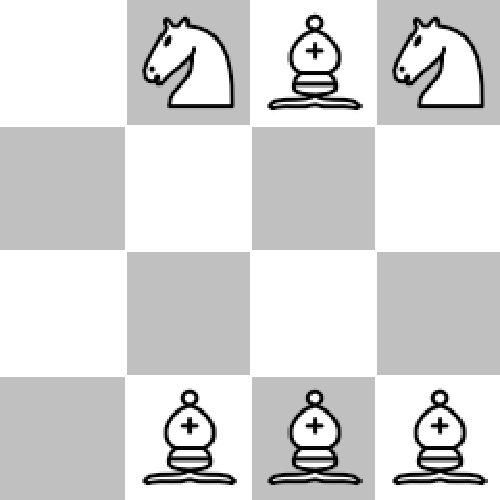

In [37]:
filtering_solution_board.resize((500, 500))

## ABT

In [130]:
SIZE = 5

In [131]:
CONFIG = {'N':12}

In [132]:
gen_list, figures_mapping, coords = create_chess_board(SIZE, CONFIG, RENAME_MAPPING,['M'], ['L'])

In [133]:
# gen_list

In [134]:
board = draw(SIZE, gen_list)

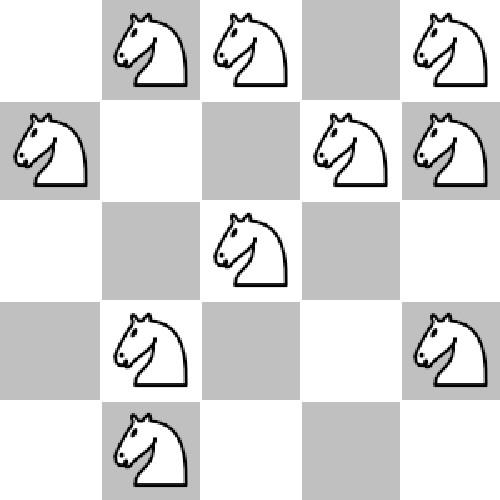

In [135]:
board.resize((500, 500))

In [136]:
figures_mapping

{(0, 1): 'N',
 (0, 2): 'N',
 (0, 4): 'N',
 (1, 0): 'N',
 (1, 3): 'N',
 (1, 4): 'N',
 (2, 2): 'N',
 (3, 1): 'N',
 (3, 4): 'N',
 (4, 1): 'N'}

In [137]:
coords

array([[ 0., 12., 12.,  0., 12.],
       [12.,  0.,  0., 12., 12.],
       [ 0.,  0., 12.,  0.,  0.],
       [ 0., 12.,  0.,  0., 12.],
       [ 0., 12.,  0.,  0.,  0.]])

In [138]:
figures_mapping

{(0, 1): 'N',
 (0, 2): 'N',
 (0, 4): 'N',
 (1, 0): 'N',
 (1, 3): 'N',
 (1, 4): 'N',
 (2, 2): 'N',
 (3, 1): 'N',
 (3, 4): 'N',
 (4, 1): 'N'}

In [139]:
all_domain = list(product(range(SIZE), range(SIZE)))

In [140]:
figures_mapping_changed_names = deepcopy(figures_mapping)

for coords_key, figure_name in figures_mapping_changed_names.items():
    new_name = '{}_{}'.format(figure_name, coords_key)
    figures_mapping_changed_names[coords_key] = new_name

In [141]:
figures_mapping_changed_names

{(0, 1): 'N_(0, 1)',
 (0, 2): 'N_(0, 2)',
 (0, 4): 'N_(0, 4)',
 (1, 0): 'N_(1, 0)',
 (1, 3): 'N_(1, 3)',
 (1, 4): 'N_(1, 4)',
 (2, 2): 'N_(2, 2)',
 (3, 1): 'N_(3, 1)',
 (3, 4): 'N_(3, 4)',
 (4, 1): 'N_(4, 1)'}

In [142]:
agents = [{'coordinates': coord, 'name': new_name, 'priority': idx + 1, 'neighbors_list': [],
           'agent_domain': all_domain, 'consistent': True, 'constraints': [], 'board': coords
          } for idx, (coord, new_name) in enumerate(figures_mapping_changed_names.items())]

In [143]:
for idx, agent in enumerate(agents):
    agent['neighbors_list'].extend([ag for ag_idx, ag in enumerate(agents) if ag_idx != idx])

In [144]:
def check_consistency(agent, board):
    consistent = True
    for neighbor in agent['neighbors_list']:
        step_coords_function = STEP_RULES_MAPPING.get(neighbor['name'].split('_')[0])
        step_coordinates = step_coords_function(neighbor['coordinates'], agent['coordinates'], board.shape[0])
        
        if (attack(step_coordinates, agent['coordinates'])
            or agent['coordinates'] == neighbor['coordinates']):
            consistent = False
    
    return consistent

In [145]:
def change_value(agent):
    agent['coordinates'] = random.choice(agent['agent_domain'])

In [146]:
def check_local_view(agent, board):
    consistent = check_consistency(agent, board)
    
    if not consistent:
        old_value = agent['coordinates']
        for domain in agent['agent_domain']:
            agent['coordinates'] = domain
            consistent = check_consistency(agent, board)
            if consistent:
                break
        if not consistent:
            for agents in agent['neighbors_list']:
                if agents['priority'] == agent['priority'] - 1:
                    master_agent = agents
            backtrack(master_agent, board)
        else:
            for agents in agent['neighbors_list']:
                send_handle_ok(agents, board)

In [147]:
def handle_ok(agent, another_agent, board):
    for neighbor in agent['neighbors_list']:
        if neighbor['name'] == another_agent['name']:
            neighbor['coordinates'] = another_agent['coordinates']
            neighbor['priority'] = another_agent['priority']
            
            check_local_view(another_agent, board)

In [148]:
def handle_nogood(agent, another_agent, nogood_list, board):
    agent['constraints'].append(nogood_list)
    for agent_in_nogood in nogood_list:
        if any(neighbor_agent['name'] == agent_in_nogood[0] for neighbor_agent in agent['neighbors_list']):
            pass
        else:
            agent['neighbors_list'].append(
                {'name': agent_in_nogood[0], 'value': agent_in_nogood[1], 'priority': agent_in_nogood[2]})
    old_value = agent['coordinates']
    check_local_view(another_agent, board)
    if old_value != agent['coordinates']:
        for agents in agent['neighbors_list']:
            send_handle_ok(agents, board)

In [149]:
def backtrack(master_agent, board):
    higher_priority_agents = []
    higher_domains = []
    for neighbor in master_agent['neighbors_list']:
        if neighbor['priority'] < master_agent['priority']:
            higher_priority_agents.append(neighbor)
    for agent in higher_priority_agents:
        higher_domains.append(agent['coordinates'])
    if master_agent['agent_domain'] == higher_domains:
        print("no_solution")
    else:
        if not (master_agent['coordinates'] in higher_domains):
            print("no_solution")
            return 0
        while master_agent['coordinates'] in higher_domains:
            master_agent['coordinates'] = random.choice(master_agent['agent_domain'])
        for agents in master_agent['neighbors_list']:
            if agents['priority'] > master_agent['priority']:
                send_handle_ok(master_agent, board)

In [150]:
def send_handle_ok(agent, board):
    for agents in agent['neighbors_list']:
        if agents:
            if agents['priority'] > agent['priority']:
                handle_ok(agents, agent, board)


def abt(agent_list, board):
    processed_agents = []
    for i, agent in enumerate(agent_list):
        check_consistency(agent, board)
        send_handle_ok(agent, board)
        processed_agents.append(agent)

        new_domain = list(set(all_domain) - set([ag['coordinates'] for ag in processed_agents]))
        agent['agent_domain'] = new_domain

        new_neighbours = []
        for neighbour in agent['neighbors_list']:
            neighbour['agent_domain'] = new_domain

            new_neighbours.append(neighbour)

        agent['neighbors_list'] = new_neighbours

In [151]:
abt(agents, coords)

In [152]:
len(agents)

10

In [153]:
agents[0]['coordinates'], agents[0]['name']

((0, 0), 'N_(0, 1)')

In [154]:
coords_sol = np.zeros((SIZE, SIZE)).astype(str)
coords_sol = [[' ' if el1 == '0.0' else el1 for el1 in el] for el in coords_sol]

In [155]:
for agent in agents:
    coords_sol[agent['coordinates'][0]][agent['coordinates'][1]] = agent['name'].split('_')[0]

In [156]:
coords_sol

[['N', 'N', 'N', ' ', 'N'],
 [' ', 'N', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', 'N'],
 [' ', 'N', ' ', ' ', 'N'],
 ['N', 'N', ' ', ' ', ' ']]

In [157]:
sol_gen = ('/').join([('').join([el if el != '0.0' else ' ' for el in row]) for row in coords_sol])

In [158]:
# sol_gen

In [159]:
sol_board = draw(SIZE, sol_gen)

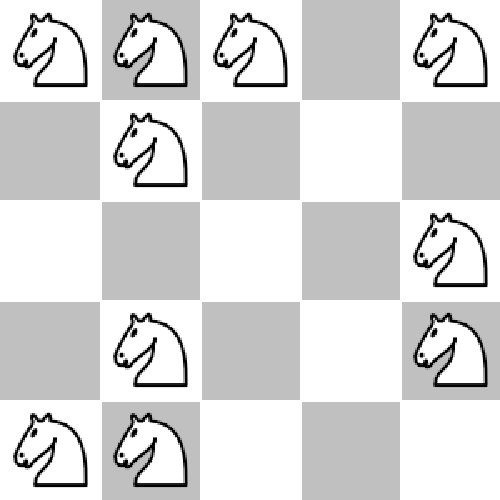

In [160]:
sol_board.resize((500, 500))